In [1]:
{-# LANGUAGE GeneralizedNewtypeDeriving #-}
{-# LANGUAGE TypeSynonymInstances #-}
{-# LANGUAGE FlexibleInstances #-}
{-# LANGUAGE RankNTypes #-}


import Data.Bits             (Bits (bit, complement, popCount, shiftR, (.&.), (.|.), testBit),
                              FiniteBits (finiteBitSize))
import Data.ByteArray.Hash   (FnvHash32 (..), fnv1Hash)
import Data.ByteString.Char8 (pack)
import Data.Char             (intToDigit)
import Data.Semigroup        ((<>))
import Data.Vector           (Vector, drop, singleton, take, replicate, (!), (//))
import Data.Word             (Word16, Word32)
import Numeric               (showIntAtBase)
import Prelude               hiding (drop, lookup, take, replicate)
import qualified             Prelude
import System.TimeIt         (timeIt)
import Text.Show.Pretty      (pPrint)

In [2]:
import IHaskell.Display.Graphviz
import Control.Monad.Trans.State.Strict
import Control.Monad.Trans.Writer.CPS
import Control.Monad.Trans.Class
import qualified Data.Vector as Vector
import Data.List (intercalate, intersperse, foldl')

In [3]:
getFreshId :: State Int Int
getFreshId = do
    currentId <- get
    put (currentId+1)
    pure currentId

escape = concatMap escaper
    where
        escaper :: Char -> String
        escaper c = case c of
            '"'  -> "\\\""
            '\\' -> "\\\\"
            _    -> [c]

makeDotLines :: [String] -> String
makeDotLines = concatMap (++ ";\n")

preamble = unlines
    [ "digraph {"
    , "node [shape=record];"
    , "splines=false;"
    , "ranksep=2;"
    , "nodesep=1;"
    ]
postamble = unlines ["}"]

makeDot :: String -> String
makeDot str = preamble ++ str ++ postamble

In [4]:
newtype Binary a = Binary a
    deriving (Enum, Ord, Real, Integral, Eq, Num, Bits, FiniteBits)

instance (FiniteBits a, Show a, Integral a) => Show (Binary a) where
    show (Binary n) = let
        str = showIntAtBase 2 intToDigit n ""
        size = finiteBitSize n
        in Prelude.replicate (size - length str) '0' <> str

In [5]:
type Hash = Binary Word32

class Hashable a where
    hash :: a -> Hash

In [6]:
instance Hashable String where
    hash s = let
        FnvHash32 h = fnv1Hash (pack s)
        in Binary h

instance Hashable Int where
    hash int = Binary (fromIntegral int)

In [7]:
class Mapping mapping where
    empty :: forall k v. mapping k v
    lookup :: forall k v. (Hashable k) => k -> mapping k v -> Maybe v
    insert :: forall k v. (Hashable k) => k -> v -> mapping k v -> mapping k v

In [8]:
fib' :: (Mapping m) => m Int Integer -> Int -> (Integer, m Int Integer)
fib' table 0 = (1, insert 0 1 table)
fib' table 1 = (1, insert 1 1 table)
fib' table n = case lookup n table of
    Just i -> (i, table)
    Nothing -> let
        (i1, table')  = fib' table  (n-1)
        (i2, table'') = fib' table' (n-2)
        in (i1 + i2, insert n (i1 + i2) table'')

In [9]:
data HashBinaryMappedTrie key value
    = HashBinaryMappedTrieNone
    | HashBinaryMappedTrieLeaf Hash key value
    | HashBinaryMappedTrieNode
        (HashBinaryMappedTrie key value)
        (HashBinaryMappedTrie key value)
    deriving (Eq, Show)

In [10]:
emptyHashBinaryMappedTrie = HashBinaryMappedTrieNone

In [11]:
insertHashBinaryMappedTrie :: (Hashable key) => key -> value -> HashBinaryMappedTrie key value -> HashBinaryMappedTrie key value
insertHashBinaryMappedTrie key = insertHashBinaryMappedTrieHelper 0 (hash key) key

insertHashBinaryMappedTrieHelper :: Int -> Hash -> key -> value -> HashBinaryMappedTrie key value -> HashBinaryMappedTrie key value
insertHashBinaryMappedTrieHelper depth hash key value HashBinaryMappedTrieNone =
    HashBinaryMappedTrieLeaf hash key value
insertHashBinaryMappedTrieHelper depth hash key value (HashBinaryMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = HashBinaryMappedTrieLeaf hash key value
    | otherwise = let
        emptyNode = HashBinaryMappedTrieNode HashBinaryMappedTrieNone HashBinaryMappedTrieNone
        leafInsertedNode = insertHashBinaryMappedTrieHelper depth leafHash leafKey leafValue emptyNode
        in insertHashBinaryMappedTrieHelper depth hash key value leafInsertedNode
insertHashBinaryMappedTrieHelper depth hash key value (HashBinaryMappedTrieNode left right) = let
    goRight = testBit hash depth
    depth' = depth + 1
    in if goRight
        then HashBinaryMappedTrieNode left (insertHashBinaryMappedTrieHelper depth' hash key value right)
        else HashBinaryMappedTrieNode (insertHashBinaryMappedTrieHelper depth' hash key value left) right

In [12]:
lookupHashBinaryMappedTrie :: (Hashable key) => key -> HashBinaryMappedTrie key value -> Maybe value
lookupHashBinaryMappedTrie key = lookupHashBinaryMappedTrieHelper 0 (hash key) key

lookupHashBinaryMappedTrieHelper :: Int -> Hash -> key -> HashBinaryMappedTrie key value -> Maybe value
lookupHashBinaryMappedTrieHelper depth hash key HashBinaryMappedTrieNone = Nothing
lookupHashBinaryMappedTrieHelper depth hash key (HashBinaryMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = Just leafValue
    | otherwise = Nothing
lookupHashBinaryMappedTrieHelper depth hash key (HashBinaryMappedTrieNode left right) = let
    goRight = testBit hash depth
    depth' = depth + 1
    in if goRight
        then lookupHashBinaryMappedTrieHelper depth' hash key right
        else lookupHashBinaryMappedTrieHelper depth' hash key left

In [13]:
instance Mapping HashBinaryMappedTrie where
    empty = emptyHashBinaryMappedTrie
    insert = insertHashBinaryMappedTrie
    lookup = lookupHashBinaryMappedTrie

In [14]:
data HashBinaryMappedTrieGraphvizNode
    = HashBinaryMappedTrieGraphvizNode
        { hashBinaryMappedTrieGraphvizNodeId :: Int
        , hashBinaryMappedTrieGraphvizLeftChildId :: Int
        , hashBinaryMappedTrieGraphvizRightChildId :: Int
        }
    | HashBinaryMappedTrieGraphvizLeafNode
        { hashBinaryMappedTrieGraphvizLeafNodeId :: Int
        , hashBinaryMappedTriGraphvizeLeafHash :: String
        , hashBinaryMappedTrieGraphvizLeafKey :: String
        , hashBinaryMappedTrieGraphvizLeafNodeValue :: String
        }
    deriving (Eq, Show)

numberHBMT :: (Show k, Show v) => HashBinaryMappedTrie k v -> WriterT [HashBinaryMappedTrieGraphvizNode] (State Int) Int
numberHBMT HashBinaryMappedTrieNone = do
    tell mempty
    pure 0
numberHBMT (HashBinaryMappedTrieLeaf h k v) = do
    i <- lift getFreshId
    tell [HashBinaryMappedTrieGraphvizLeafNode i (show h) (show k) (show v)]
    pure i
numberHBMT (HashBinaryMappedTrieNode l r) = do
    i <- lift getFreshId
    leftChildId <- numberHBMT l
    rightChildId <- numberHBMT r
    tell [HashBinaryMappedTrieGraphvizNode i leftChildId rightChildId]
    pure i

nodeLinesHBMT :: HashBinaryMappedTrieGraphvizNode -> [String]
nodeLinesHBMT (HashBinaryMappedTrieGraphvizLeafNode i h k v) = let
    label = intercalate "|" [h, k, v]
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in [line]
nodeLinesHBMT (HashBinaryMappedTrieGraphvizNode i l r) = let
    edges = map (\index -> "n" ++ show i ++ " -> " ++ "n" ++ show index) [l, r]
    label = "n" ++ show i ++ " " ++ "[label=\"\"]"
    in label:edges

dotFromHBMT :: (Show k, Show v) => HashBinaryMappedTrie k v -> String
dotFromHBMT = makeDot . makeDotLines. concatMap nodeLinesHBMT . flip evalState 0 . execWriterT . numberHBMT

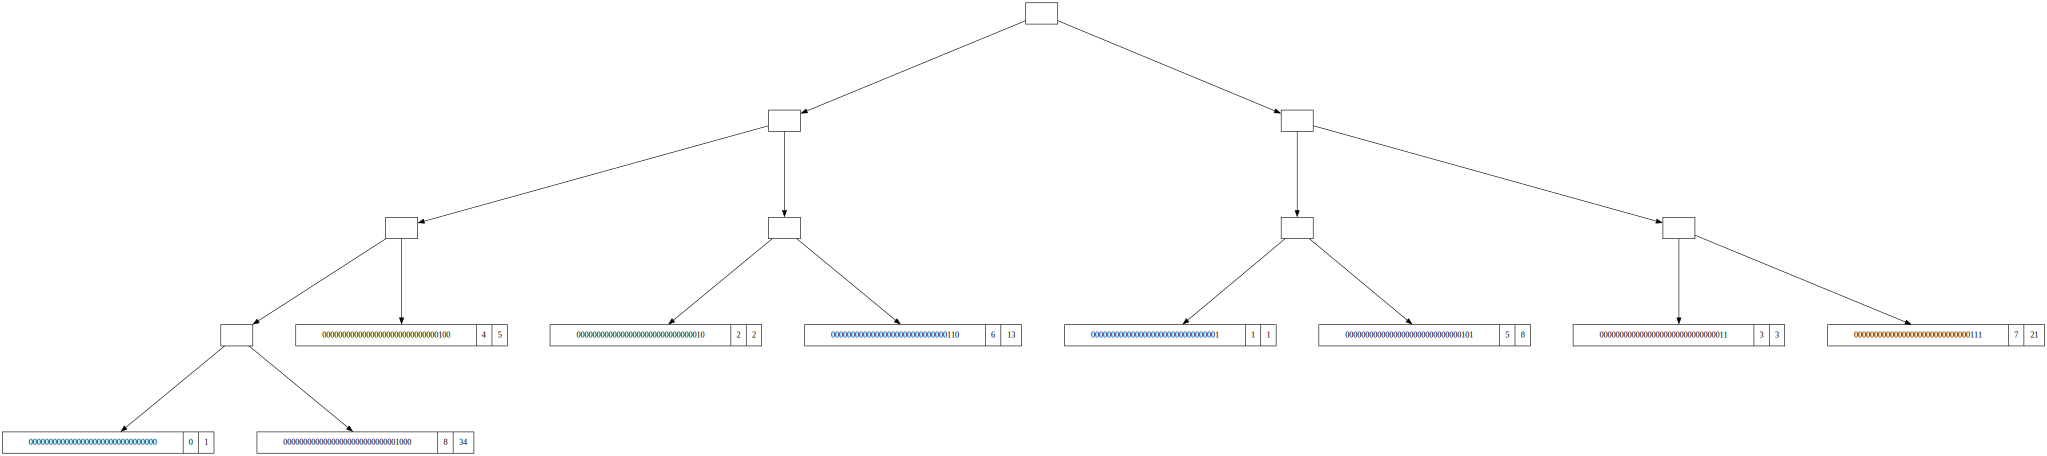

In [15]:
dot $ dotFromHBMT $ snd $ fib' emptyHashBinaryMappedTrie 8

In [16]:
data Hash2ArrayMappedTrie key value
    = Hash2ArrayMappedTrieNone
    | Hash2ArrayMappedTrieLeaf Hash key value
    | Hash2ArrayMappedTrieNode (Vector (Hash2ArrayMappedTrie key value))
    deriving (Eq, Show)

In [17]:
emptyHash2ArrayMappedTrie = Hash2ArrayMappedTrieNone

In [18]:
insertHash2ArrayMappedTrie :: (Hashable key) => key -> value -> Hash2ArrayMappedTrie key value -> Hash2ArrayMappedTrie key value
insertHash2ArrayMappedTrie key = insertHash2ArrayMappedTrieHelper 0 (hash key) key

insertHash2ArrayMappedTrieHelper :: Int -> Hash -> key -> value -> Hash2ArrayMappedTrie key value -> Hash2ArrayMappedTrie key value
insertHash2ArrayMappedTrieHelper depth hash key value Hash2ArrayMappedTrieNone =
    Hash2ArrayMappedTrieLeaf hash key value
insertHash2ArrayMappedTrieHelper depth hash key value (Hash2ArrayMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = Hash2ArrayMappedTrieLeaf hash key value
    | otherwise = let
        emptyNode = Hash2ArrayMappedTrieNode (replicate 2 Hash2ArrayMappedTrieNone)
        leafInsertedNode = insertHash2ArrayMappedTrieHelper depth leafHash leafKey leafValue emptyNode
        in insertHash2ArrayMappedTrieHelper depth hash key value leafInsertedNode
insertHash2ArrayMappedTrieHelper depth hash key value (Hash2ArrayMappedTrieNode children) = let
    goRight = testBit hash depth
    depth' = depth + 1
    in if goRight
        then Hash2ArrayMappedTrieNode $ children // [(1, insertHash2ArrayMappedTrieHelper depth' hash key value (children ! 1))]
        else Hash2ArrayMappedTrieNode $ children // [(0, insertHash2ArrayMappedTrieHelper depth' hash key value (children ! 0))]

In [19]:
lookupHash2ArrayMappedTrie :: (Hashable key) => key -> Hash2ArrayMappedTrie key value -> Maybe value
lookupHash2ArrayMappedTrie key = lookupHash2ArrayMappedTrieHelper 0 (hash key) key

lookupHash2ArrayMappedTrieHelper :: Int -> Hash -> key -> Hash2ArrayMappedTrie key value -> Maybe value
lookupHash2ArrayMappedTrieHelper depth hash key Hash2ArrayMappedTrieNone = Nothing
lookupHash2ArrayMappedTrieHelper depth hash key (Hash2ArrayMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = Just leafValue
    | otherwise = Nothing
lookupHash2ArrayMappedTrieHelper depth hash key (Hash2ArrayMappedTrieNode children) = let
    goRight = testBit hash depth
    depth' = depth + 1
    in if goRight
        then lookupHash2ArrayMappedTrieHelper depth' hash key (children ! 1)
        else lookupHash2ArrayMappedTrieHelper depth' hash key (children ! 0)

In [20]:
instance Mapping Hash2ArrayMappedTrie where
    empty = emptyHash2ArrayMappedTrie
    insert = insertHash2ArrayMappedTrie
    lookup = lookupHash2ArrayMappedTrie

In [21]:
data Hash2ArrayMappedTrieGraphvizNode
    = Hash2ArrayMappedTrieGraphvizNode
        { hash2ArrayMappedTrieGraphvizNodeId :: Int
        , hash2ArrayMappedTrieGraphvizFields :: [Int]
        }
    | Hash2ArrayMappedTrieGraphvizLeafNode
        { hash2ArrayMappedTrieGraphvizLeafNodeId :: Int
        , hash2ArrayMappedTrieGraphvizLeafHash :: String
        , hash2ArrayMappedTrieGraphvizLeafKey :: String
        , hash2ArrayMappedTrieGraphvizLeafNodeValue :: String
        }
    deriving (Eq, Show)

numberH2AMT :: (Show k, Show v) => Hash2ArrayMappedTrie k v -> WriterT [Hash2ArrayMappedTrieGraphvizNode] (State Int) Int
numberH2AMT Hash2ArrayMappedTrieNone = do
    tell mempty
    pure 0
numberH2AMT (Hash2ArrayMappedTrieLeaf h k v) = do
    i <- lift getFreshId
    tell [Hash2ArrayMappedTrieGraphvizLeafNode i (show h) (show k) (show v)]
    pure i
numberH2AMT (Hash2ArrayMappedTrieNode hs) = do
    i <- lift getFreshId
    numbered <- Vector.toList <$> traverse numberH2AMT hs
    tell [Hash2ArrayMappedTrieGraphvizNode i numbered]
    pure i

nodeLinesH2AMT :: Hash2ArrayMappedTrieGraphvizNode -> [String]
nodeLinesH2AMT (Hash2ArrayMappedTrieGraphvizLeafNode i h k v) = let
    label = intercalate "|" [h, k, v]
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in [line]
nodeLinesH2AMT (Hash2ArrayMappedTrieGraphvizNode i fs) = let
    indices = Prelude.take (length fs) [0..]
    pairs = zip indices fs
    edges = flip map pairs $ \(f,t) -> "n" ++ show i ++ ":" ++ "f" ++ show f ++ " -> " ++ "n" ++ show t
    fields = flip map indices $ \ix -> "<f" ++ show ix ++ ">"
    label = intercalate "|" fields
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in (line:edges)

dotFromH2AMT :: (Show k, Show v) => Hash2ArrayMappedTrie k v -> String
dotFromH2AMT = makeDot . makeDotLines. concatMap nodeLinesH2AMT . flip evalState 0 . execWriterT . numberH2AMT

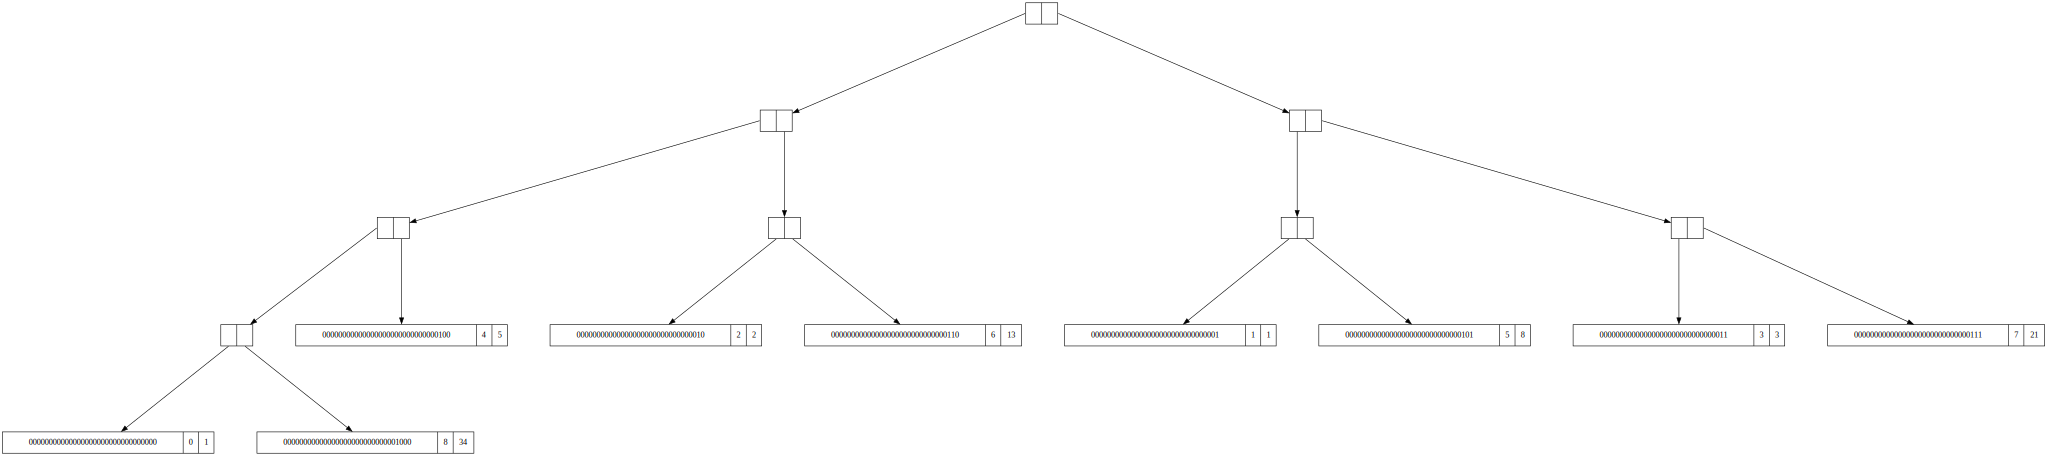

In [22]:
dot $ dotFromH2AMT $ snd $ fib' emptyHash2ArrayMappedTrie 8

In [23]:
data HashArrayMappedTrieSpacious key value
    = HashArrayMappedTrieSpaciousNone
    | HashArrayMappedTrieSpaciousLeaf Hash key value
    | HashArrayMappedTrieSpaciousNode (Vector (HashArrayMappedTrieSpacious key value))
    deriving (Eq, Show)

In [24]:
emptyHashArrayMappedTrieSpacious = HashArrayMappedTrieSpaciousNone

In [25]:
hashFragmentLength :: Int
hashFragmentLength = 4

hashMask = bit hashFragmentLength - 1 -- 0b1111

In [26]:
insertHashArrayMappedTrieSpacious :: (Hashable key) => key -> value -> HashArrayMappedTrieSpacious key value -> HashArrayMappedTrieSpacious key value
insertHashArrayMappedTrieSpacious key = insertHashArrayMappedTrieSpaciousHelper 0 (hash key) key

insertHashArrayMappedTrieSpaciousHelper :: Int -> Hash -> key -> value -> HashArrayMappedTrieSpacious key value -> HashArrayMappedTrieSpacious key value
insertHashArrayMappedTrieSpaciousHelper depth hash key value HashArrayMappedTrieSpaciousNone =
    HashArrayMappedTrieSpaciousLeaf hash key value
insertHashArrayMappedTrieSpaciousHelper depth hash key value (HashArrayMappedTrieSpaciousLeaf leafHash leafKey leafValue)
    | hash == leafHash = HashArrayMappedTrieSpaciousLeaf hash key value
    | otherwise = let
        emptyNode = HashArrayMappedTrieSpaciousNode (replicate (2^hashFragmentLength) HashArrayMappedTrieSpaciousNone)
        leafInsertedNode = insertHashArrayMappedTrieSpaciousHelper depth leafHash leafKey leafValue emptyNode
        in insertHashArrayMappedTrieSpaciousHelper depth hash key value leafInsertedNode
insertHashArrayMappedTrieSpaciousHelper depth hash key value (HashArrayMappedTrieSpaciousNode children) = let
    hashFragment = (hash `shiftR` depth) .&. hashMask
    index = fromIntegral hashFragment
    depth' = depth + hashFragmentLength
    in HashArrayMappedTrieSpaciousNode
        (children // [(index, insertHashArrayMappedTrieSpaciousHelper depth' hash key value (children ! index))])

In [27]:
lookupHashArrayMappedTrieSpacious :: (Hashable key) => key -> HashArrayMappedTrieSpacious key value -> Maybe value
lookupHashArrayMappedTrieSpacious key = lookupHashArrayMappedTrieSpaciousHelper 0 (hash key) key

lookupHashArrayMappedTrieSpaciousHelper :: Int -> Hash -> key -> HashArrayMappedTrieSpacious key value -> Maybe value
lookupHashArrayMappedTrieSpaciousHelper depth hash key HashArrayMappedTrieSpaciousNone = Nothing
lookupHashArrayMappedTrieSpaciousHelper depth hash key (HashArrayMappedTrieSpaciousLeaf leafHash leafKey leafValue)
    | hash == leafHash = Just leafValue
    | otherwise = Nothing
lookupHashArrayMappedTrieSpaciousHelper depth hash key (HashArrayMappedTrieSpaciousNode children) = let
    hashFragment = (hash `shiftR` depth) .&. hashMask
    index = fromIntegral hashFragment
    depth' = depth + hashFragmentLength
    in lookupHashArrayMappedTrieSpaciousHelper depth' hash key (children ! index)

In [28]:
instance Mapping HashArrayMappedTrieSpacious where
    empty = emptyHashArrayMappedTrieSpacious
    insert = insertHashArrayMappedTrieSpacious
    lookup = lookupHashArrayMappedTrieSpacious

In [29]:
data HashArrayMappedTrieSpaciousGraphvizNode
    = HashArrayMappedTrieSpaciousGraphvizNode
        { hashArrayMappedTrieSpaciousGraphvizNodeId :: Int
        , hashArrayMappedTrieSpaciousGraphvizFields :: [Int]
        }
    | HashArrayMappedTrieSpaciousGraphvizLeafNode
        { hashArrayMappedTrieSpaciousGraphvizLeafNodeId :: Int
        , hashArrayMappedTrieSpaciousGraphvizLeafHash :: String
        , hashArrayMappedTrieSpaciousGraphvizLeafKey :: String
        , hashArrayMappedTrieSpaciousGraphvizLeafNodeValue :: String
        }
    deriving (Eq, Show)

numberHAMTS :: (Show k, Show v) => HashArrayMappedTrieSpacious k v -> WriterT [HashArrayMappedTrieSpaciousGraphvizNode] (State Int) Int
numberHAMTS HashArrayMappedTrieSpaciousNone = do
    tell mempty
    pure 0
numberHAMTS (HashArrayMappedTrieSpaciousLeaf h k v) = do
    i <- lift getFreshId
    tell [HashArrayMappedTrieSpaciousGraphvizLeafNode i (show h) (show k) (show v)]
    pure i
numberHAMTS (HashArrayMappedTrieSpaciousNode hs) = do
    i <- lift getFreshId
    numbered <- Vector.toList <$> traverse numberHAMTS hs
    tell [HashArrayMappedTrieSpaciousGraphvizNode i numbered]
    pure i

nodeLinesHAMTS :: HashArrayMappedTrieSpaciousGraphvizNode -> [String]
nodeLinesHAMTS (HashArrayMappedTrieSpaciousGraphvizLeafNode i h k v) = let
    label = intercalate "|" [h, k, v]
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in [line]
nodeLinesHAMTS (HashArrayMappedTrieSpaciousGraphvizNode i fs) = let
    indices = Prelude.take (length fs) [0..]
    pairs = filter (\(_,i) -> i /= 0) $ zip indices fs
    edges = flip map pairs $ \(f,t) -> "n" ++ show i ++ ":" ++ "f" ++ show f ++ " -> " ++ "n" ++ show t
    fields = flip map indices $ \ix -> "<f" ++ show ix ++ ">"
    label = intercalate "|" fields
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in (line:edges)

dotFromHAMTS :: (Show k, Show v) => HashArrayMappedTrieSpacious k v -> String
dotFromHAMTS = makeDot . makeDotLines. concatMap nodeLinesHAMTS . flip evalState 0 . execWriterT . numberHAMTS

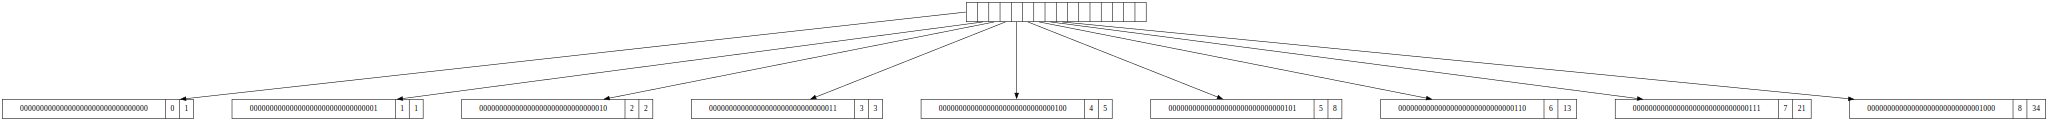

In [30]:
dot $ dotFromHAMTS $ snd $ fib' emptyHashArrayMappedTrieSpacious 8

In [ ]:
data HashArrayMappedTrie key value
    = HashArrayMappedTrieNone
    | HashArrayMappedTrieLeaf Hash key value
    | HashArrayMappedTrieNode (Binary Word16) (Vector (HashArrayMappedTrie key value))
    deriving (Eq, Show)

In [ ]:
emptyHashArrayMappedTrie = HashArrayMappedTrieNone

In [ ]:
insertHashArrayMappedTrie :: (Hashable key) => key -> value -> HashArrayMappedTrie key value -> HashArrayMappedTrie key value
insertHashArrayMappedTrie key = insertHashArrayMappedTrieHelper 0 (hash key) key

insertHashArrayMappedTrieHelper :: Int -> Hash -> key -> value -> HashArrayMappedTrie key value -> HashArrayMappedTrie key value
insertHashArrayMappedTrieHelper depth hash key value HashArrayMappedTrieNone =
    HashArrayMappedTrieLeaf hash key value
insertHashArrayMappedTrieHelper depth hash key value leaf@(HashArrayMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = HashArrayMappedTrieLeaf hash key value
    | otherwise = let
        leafHashFragment = (leafHash `shiftR` depth) .&. hashMask
        leafBitmap = bit (fromIntegral leafHashFragment)
        leafInsertedNode = HashArrayMappedTrieNode leafBitmap (singleton leaf)
        in insertHashArrayMappedTrieHelper depth hash key value leafInsertedNode
insertHashArrayMappedTrieHelper depth hash key value (HashArrayMappedTrieNode bitmap children) = let
    hashFragment = (hash `shiftR` depth) .&. hashMask
    elemBitmap = bit (fromIntegral hashFragment)
    index = popCount (bitmap .&. (elemBitmap - 1))
    depth' = depth + hashFragmentLength
    in if elemBitmap .&. bitmap == 0
        then let
            leaf = HashArrayMappedTrieLeaf hash key value
            bitmap' = bitmap .|. elemBitmap
            children' = take index children <> singleton leaf <> drop index children
            in HashArrayMappedTrieNode bitmap' children'
        else let
            subtree = children ! index
            subtree' = insertHashArrayMappedTrieHelper depth' hash key value subtree
            children' = children // [(index, subtree')]
            in HashArrayMappedTrieNode bitmap children'

In [ ]:
lookupHashArrayMappedTrie :: (Hashable key) => key -> HashArrayMappedTrie key value -> Maybe value
lookupHashArrayMappedTrie key = lookupHashArrayMappedTrieHelper 0 (hash key) key

lookupHashArrayMappedTrieHelper :: Int -> Hash -> key -> HashArrayMappedTrie key value -> Maybe value
lookupHashArrayMappedTrieHelper depth hash key HashArrayMappedTrieNone = Nothing
lookupHashArrayMappedTrieHelper depth hash key (HashArrayMappedTrieLeaf leafHash leafKey leafValue)
    | hash == leafHash = Just leafValue
    | otherwise = Nothing
lookupHashArrayMappedTrieHelper depth hash key (HashArrayMappedTrieNode bitmap children) = let
    hashFragment = (hash `shiftR` depth) .&. hashMask
    elemBitmap = bit (fromIntegral hashFragment)
    index = popCount (bitmap .&. (elemBitmap - 1))
    depth' = depth + hashFragmentLength
    in if elemBitmap .&. bitmap == 0
        then Nothing
        else lookupHashArrayMappedTrieHelper depth' hash key (children ! index)

In [ ]:
instance Mapping HashArrayMappedTrie where
    empty = emptyHashArrayMappedTrie
    insert = insertHashArrayMappedTrie
    lookup = lookupHashArrayMappedTrie

In [ ]:
data HashArrayMappedTrieGraphvizNode
    = HashArrayMappedTrieGraphvizNode
        { hashArrayMappedTrieGraphvizNodeId :: Int
        , hashArrayMappedTrieGraphvizBitmap :: String
        , hashArrayMappedTrieGraphvizFields :: [Int]
        }
    | HashArrayMappedTrieGraphvizLeafNode
        { hashArrayMappedTrieGraphvizLeafNodeId :: Int
        , hashArrayMappedTrieGraphvizLeafHash :: String
        , hashArrayMappedTrieGraphvizLeafKey :: String
        , hashArrayMappedTrieGraphvizLeafNodeValue :: String
        }
    deriving (Eq, Show)

numberHAMT :: (Show k, Show v) => HashArrayMappedTrie k v -> WriterT [HashArrayMappedTrieGraphvizNode] (State Int) Int
numberHAMT HashArrayMappedTrieNone = do
    tell mempty
    pure 0
numberHAMT (HashArrayMappedTrieLeaf h k v) = do
    i <- lift getFreshId
    tell [HashArrayMappedTrieGraphvizLeafNode i (show h) (show k) (show v)]
    pure i
numberHAMT (HashArrayMappedTrieNode b hs) = do
    i <- lift getFreshId
    numbered <- Vector.toList <$> traverse numberHAMT hs
    tell [HashArrayMappedTrieGraphvizNode i (show b) numbered]
    pure i

nodeLinesHAMT :: HashArrayMappedTrieGraphvizNode -> [String]
nodeLinesHAMT (HashArrayMappedTrieGraphvizLeafNode i h k v) = let
    label = intercalate "|" [h, k, v]
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in [line]
nodeLinesHAMT (HashArrayMappedTrieGraphvizNode i b fs) = let
    indices = Prelude.take (length fs) [0..]
    pairs = zip indices fs
    edges = flip map pairs $ \(f,t) -> "n" ++ show i ++ ":" ++ "f" ++ show f ++ " -> " ++ "n" ++ show t
    fields = flip map indices $ \ix -> "<f" ++ show ix ++ ">"
    label = intercalate "|" $ b:fields
    line = ("n" ++ show i) ++ " " ++ "[label=\"" ++ escape label ++ "\"]"
    in (line:edges)

dotFromHAMT :: (Show k, Show v) => HashArrayMappedTrie k v -> String
dotFromHAMT = makeDot . makeDotLines. concatMap nodeLinesHAMT . flip evalState 0 . execWriterT . numberHAMT

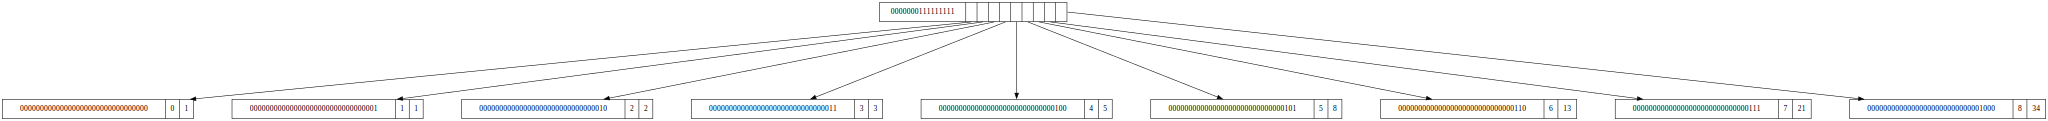

In [ ]:
dot $ dotFromHAMT $ snd $ fib' emptyHashArrayMappedTrie 8